In [40]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

proj_dir = r"C:\Users\admin\Desktop\AXA\PSCC18_paper"
case_id = 'new39'
# OPF vs. SCOPF
case_solver = 'opf'
case_name = case_id + '_' + case_solver
gen_model = 'genrou' #'gencls'
gen_trip = False if case_solver=='scopf' else True
agc_on = 0
abus_ref = 0
res_name = '%s_%s_trip%1d_refa%d_agc%d' % (case_name, gen_model, int(gen_trip), abus_ref, agc_on)
res_name_ebsc = '%s_%s_trip%1d_refa%d_agc%d' % (case_name, gen_model, int(True), abus_ref, agc_on)

info_xl = os.path.join(proj_dir, "input_new.xlsx")
sime_xl = os.path.join(proj_dir, 'results', res_name, res_name+"_tsa.xlsx")
ebsc_bus_xl = os.path.join(proj_dir, 'results', res_name_ebsc+'_bus', res_name_ebsc+"_bus_faults.xlsx")
ebsc_line_xl = os.path.join(proj_dir, 'results', res_name_ebsc, res_name_ebsc+"_faults.xlsx")

bus_pos = { 1: (0, 2), 2: (0, 3), 3: (1, 3), 4: (1, 2), 5: (1, 1), 6: (2, 1), 7: (2, 0), 8: (1, 0), 9: (0, 0), 10: (4, 0), 11: (3, 1), 12: (4, 1), 13: (5, 1), 14: (2, 2),
            15: (3, 2), 16: (3, 3), 17: (2, 3), 18: (1, 4), 19: (6, 1), 20: (5, 2), 21: (4, 3), 22: (5, 3), 23: (6, 5), 24: (4, 4), 25: (1, 5), 26: (2, 5), 27: (2, 4),
            28: (3, 4), 29: (3, 5), 30: (0, 1), 31: (3, 0), 32: (5, 0), 33: (6, 0), 34: (6, 2), 35: (5, 4), 36: (5, 5), 37: (0, 5), 38: (4, 5), 39: (0, 4) }

In [41]:
line_df = pd.read_excel(info_xl, sheetname='lines')
line_pairs = map(tuple, line_df[['from', 'to']].values)
tran_df = pd.read_excel(info_xl, sheetname='trans')
tran_pairs = map(tuple, tran_df[['from', 'to']].values)
branch_pairs = line_pairs + tran_pairs

gen_ids = range(30, 40)

bus_df = pd.read_excel(info_xl, sheetname='loads')
load_ids = filter(lambda b: b not in gen_ids, list(bus_df.bus[bus_df.load>0].values))
no_load_ids = filter(lambda b: b not in gen_ids, list(bus_df.bus[bus_df.load<=0].values))
bus_ids = load_ids + no_load_ids

G = nx.Graph()
G.add_edges_from(branch_pairs)

# SIME

In [42]:
sime_df = pd.read_excel(sime_xl) #, sheetname='data')
# sime_df = sime_df[sime_df.test_area]
sime_pairs = dict()
results = ['stable', 'instable']
oostrips = [True, False]
for res, result in enumerate(results):
    for oos, oostrip in enumerate(oostrips):
        test = 'false' if res==oos else 'true'
        key = test + '_' + result
        sime_pairs[key] = map(tuple, sime_df.loc[(sime_df.oostr_test==oostrip) & (sime_df.result==result) & (sime_df.pos==50),
                                                 ['line_from', 'line_to']].values)

false_stable []
false_instable []
true_instable [(5, 6), (10, 11), (10, 13), (22, 23)]
true_stable [(1, 2), (1, 30), (2, 3), (2, 25), (3, 4), (3, 18), (4, 5), (4, 14), (5, 8), (6, 7), (6, 11), (7, 8), (8, 9), (9, 30), (13, 14), (14, 15), (15, 16), (16, 17), (16, 20), (16, 21), (16, 24), (17, 18), (17, 27), (21, 22), (23, 24), (25, 26), (26, 27), (26, 28), (26, 29), (28, 29), (15, 20), (16, 28), (23, 20), (24, 28), (24, 29), (4, 30), (1, 3), (6, 14), (18, 25), (13, 20)]


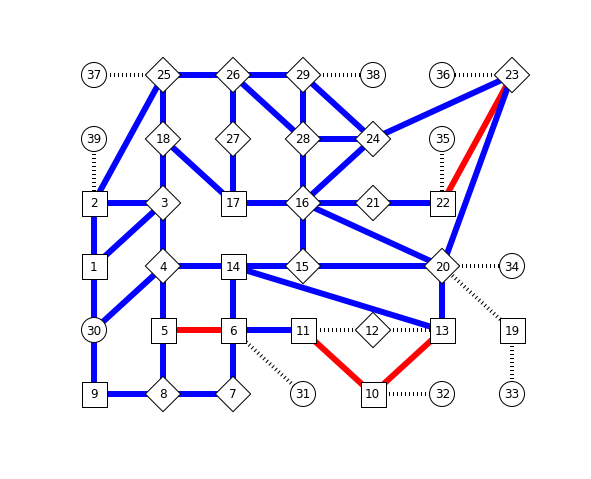

In [43]:
bus_size = 625
bus_alpha = 1

bus_labels = { id: str(id) for id in bus_ids+gen_ids }
line_alpha = 0.875
line_colors = 'black'
gen_colors = 'white'
gen_alpha = 1
load_colors = 'white'
no_load_colors = 'white'

plt.rcParams.update({'font.size': 10, 'font.family': 'sans-serif'})
fig, ax = plt.subplots(figsize=(10,8))
plt.axis('off')

# SIME
for key, pairs in sime_pairs.iteritems():
    print key, pairs
    style = 'solid' if key.startswith('true') else 'dashed'
    color, alpha = ('red', 0.99) if key.endswith('instable') else ('blue', 0.99)
    nx.draw_networkx_edges(G, pos=bus_pos, edgelist=pairs, label=key.replace('_', ' '),
                           style=style, width=6, edge_color=color, alpha=alpha, arrows=False)

# nx.draw_networkx_edges(G, pos=bus_pos, edgelist=line_pairs, style='solid', width=2,
#                        edge_color=line_colors, alpha=line_alpha, arrows=False)
nx.draw_networkx_edges(G, pos=bus_pos, edgelist=tran_pairs, style='dotted', arrows=False, width=4)

nx.draw_networkx_nodes(G, pos=bus_pos, nodelist=gen_ids, node_shape='o', node_size=bus_size, node_color=gen_colors, alpha=gen_alpha)
nx.draw_networkx_nodes(G, pos=bus_pos, nodelist=load_ids, node_shape='D', node_size=bus_size, node_color=load_colors, alpha=bus_alpha)
nx.draw_networkx_nodes(G, pos=bus_pos, nodelist=no_load_ids, node_shape='s', node_size=bus_size, node_color=no_load_colors, alpha=bus_alpha)

nx.draw_networkx_labels(G, pos=bus_pos, labels=bus_labels)

# ax.set_title('SIME results ' + case_solver.upper())
# ax.legend(loc=2, ncol=4)

plt.savefig('SIME_results_'+ case_solver +'.png', pad_inches=-0.5, bbox_inches='tight')
plt.show()



# EBSC

In [44]:
ebsc_line_ids = dict()
gen_bus_ids = [] #reduce(lambda n, nn: n + nn, map(lambda g: G.neighbors(g), range(31,40)), [])

ebsc_bus_df = pd.read_excel(ebsc_bus_xl, sheetname='gen')
ebsc_bus_ids = list(ebsc_bus_df.l_from.unique())
# AAA!!!
ebsc_bus_ids += [6, 20, 23]
if case_solver=='opf':
    ebsc_bus_ids += [10]


ebsc_line_ids['suspected'] = filter(lambda pair: not(pair in tran_pairs or (pair[1], pair[0]) in tran_pairs),
                                    G.edges(ebsc_bus_ids + gen_bus_ids))

ebsc_line_df = pd.read_excel(ebsc_line_xl, sheetname='event')
ebsc_line_ids['critical'] = map(tuple, ebsc_line_df.loc[(ebsc_line_df.l_pos==50)
                                                       & (ebsc_line_df.e_type=='oosmho')
                                                       & (ebsc_line_df.time<5),
                                                       ['l_from', 'l_to']].values)

# AAA!!!
ebsc_line_ids['critical'].remove((28,29))
if case_solver=='scopf':
    ebsc_line_ids['critical'].remove((5,6))
    ebsc_line_ids['critical'].remove((16,24))

print 'buses:', ebsc_bus_ids, ':', len(ebsc_bus_ids)
print  { k: len(ebsc_line_ids[k]) for k in ebsc_line_ids }
print sorted(ebsc_line_ids.values())

buses: [11, 13, 19, 23, 6, 20, 23, 10] : 8
{'suspected': 15, 'critical': 5}
[[(5, 6), (10, 11), (10, 13), (10, 13), (22, 23)], [(11, 10), (11, 6), (13, 10), (13, 20), (13, 14), (23, 24), (23, 20), (23, 22), (6, 5), (6, 14), (6, 7), (20, 15), (20, 16), (23, 24), (23, 22)]]


In [45]:
def get_ebsc_bus_color(bus_id, good='white', bad='red'):
    test_ebsc = bus_id in ebsc_bus_ids
    test_tran = not all(map(lambda pair: pair in tran_pairs or (pair[1], pair[0]) in tran_pairs, G.edges(bus_id)))
    test_gen = False #any(map(lambda bus: bus in gen_ids, G.neighbors(bus_id)))
    test = (test_ebsc or test_gen) and test_tran #test_gen
    return bad if test else good

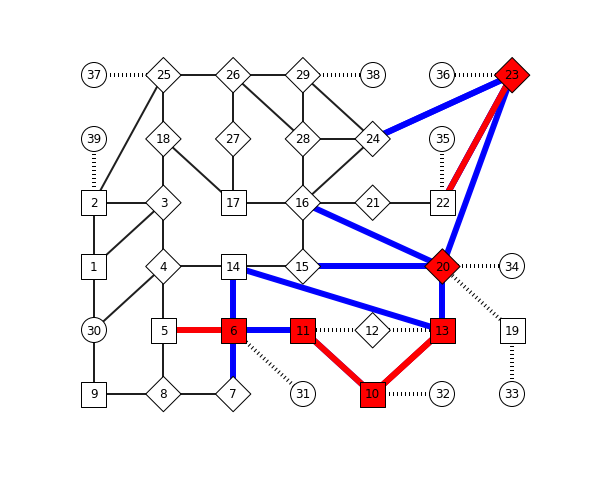

In [46]:
bus_size = 625
bus_alpha = 1

bus_labels = { id: str(id) for id in bus_ids+gen_ids }
line_alpha = 0.875
line_colors = 'black'
gen_colors = 'white'
gen_alpha = 1
load_colors = map(get_ebsc_bus_color, load_ids)
no_load_colors = map(get_ebsc_bus_color, no_load_ids)


plt.rcParams.update({'font.size': 10, 'font.family': 'sans-serif'})
fig, ax = plt.subplots(figsize=(10,8))
plt.axis('off')

# SIME
nx.draw_networkx_edges(G, pos=bus_pos, edgelist=line_pairs, style='solid', width=2,
                       edge_color=line_colors, alpha=line_alpha, arrows=False)
nx.draw_networkx_edges(G, pos=bus_pos, edgelist=tran_pairs, style='dotted', arrows=False, width=4)

nx.draw_networkx_edges(G, pos=bus_pos, edgelist=ebsc_line_ids['suspected'], label='suspected',
                       style=style, width=6, edge_color='blue', alpha=0.99, arrows=False)
nx.draw_networkx_edges(G, pos=bus_pos, edgelist=ebsc_line_ids['critical'], label='critical',
                       style=style, width=6, edge_color='red', alpha=0.99, arrows=False)




nx.draw_networkx_nodes(G, pos=bus_pos, nodelist=gen_ids, node_shape='o', node_size=bus_size, node_color=gen_colors, alpha=gen_alpha)
nx.draw_networkx_nodes(G, pos=bus_pos, nodelist=load_ids, node_shape='D', node_size=bus_size, node_color=load_colors, alpha=bus_alpha)
nx.draw_networkx_nodes(G, pos=bus_pos, nodelist=no_load_ids, node_shape='s', node_size=bus_size, node_color=no_load_colors, alpha=bus_alpha)

nx.draw_networkx_labels(G, pos=bus_pos, labels=bus_labels)

# ax.set_title('EBSC results ' + case_solver.upper())
# ax.legend(loc=2, ncol=2)
plt.savefig('EBSC_results_'+ case_solver +'.png', pad_inches=-0.5, bbox_inches='tight')
plt.show()
